In [1]:
import shioaji as sj
import pysimulation

api = sj.Shioaji(simulation=True)
accounts = api.login(
    api_key="",
    secret_key=""
)

2023-04-30 22:54:48.603 | WARNING  | importlib._bootstrap:_call_with_frames_removed:219 - Optional: pip install shioaji[speed] for better performance.


Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


In [ ]:
import datetime
import pandas as pd
from backtesting.lib import OHLCV_AGG

days = 365

# last_days = datetime.datetime.now() - datetime.timedelta(days=days)
last_days = datetime.datetime(2022, 4, 24)

kbars = api.kbars(
    contract=api.Contracts.Futures.TXF.TXFR1, 
    start=last_days.strftime("%Y-%m-%d"), 
    end=last_days.strftime("%Y-%m-%d"),
)

df = pd.DataFrame({**kbars})
df.ts = pd.to_datetime(df.ts)
df = df.set_index('ts')
df.index.name = None
df_1min = df

for i in range(days-1):
    date = last_days + datetime.timedelta(days=i+1)
    print(date.strftime("%Y-%m-%d"))
    kbars = api.kbars(
        contract=api.Contracts.Futures.TXF.TXFR1, 
        start=date.strftime("%Y-%m-%d"), 
        end=date.strftime("%Y-%m-%d"),
    )
    if kbars['ts'] != []:
        df = pd.DataFrame({**kbars})
        df.ts = pd.to_datetime(df.ts)
        df = df.set_index('ts')
        df.index.name = None
        df_1min = pd.concat([df_1min, df], axis=0)

df_1min = df_1min.between_time('00:00:00', '23:59:59')
df_1min = df_1min[['Open', 'High', 'Low', 'Close', 'Volume']]
df_1min.to_csv('TXF_1min.csv')

In [27]:
import datetime
import pandas as pd
import os
from backtesting.lib import OHLCV_AGG

df = pd.read_csv(f"TXF_1min.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = df.resample('10T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum'
    })
df.dropna(axis=0, inplace=True)

In [30]:
from backtesting import Strategy
from backtesting.lib import crossover, cross
import talib as ta
from datetime import time



class myStrategy(Strategy): 
    adx_period = 30
    rsi_period = 12
    overbought = 70
    oversold = 30

    def init(self):
        self.adx = self.I(ta.ADX, self.data.High, self.data.Low, self.data.Close, self.adx_period)
        self.rsi = self.I(ta.RSI, self.data.Close, self.rsi_period)
        self.slope1 = self.I(ta.LINEARREG_SLOPE, self.data.Close, self.rsi_period)
        self.slope2 = self.I(ta.LINEARREG_SLOPE, self.rsi, self.rsi_period)
        self.threeUpSoider = self.I(ta.CDL3WHITESOLDIERS, self.data.Open, self.data.High, self.data.Low, self.data.Close)
        self.threeDownCrow = self.I(ta.CDL3BLACKCROWS, self.data.Open, self.data.High, self.data.Low, self.data.Close)
    def next(self):
        # operating time : 9:15~13:05, stop loss = 0.4%, take profit = 3%
        if (self.data.index[-1].time() < time(13, 15)) and (self.data.index[-1].time() >= time(9, 15)):
            if (self.rsi >= self.overbought) and ((self.adx[-1] < 20) or crossover(25, self.adx)) and self.position.is_long:    # ok
                self.position.close()   # ok
                self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035))  # ok
            elif (self.rsi <= self.oversold) and ((self.adx[-1] < 20) or crossover(25, self.adx)) and self.position.is_short:   # ok
                self.position.close()   # ok
                self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))  # ok
            elif crossover(self.overbought, self.rsi) and ((self.adx[-1]>=30) or crossover(self.adx, 25)) and (not self.position):  # ok
                self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035)) # ok
            elif crossover(self.rsi, self.oversold) and ((self.adx[-1]>=30) or crossover(self.adx, 25)) and (not self.position):    # ok
                self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))  # ok
            elif (self.rsi>45) and self.adx[-1]>=25 and (self.slope1[-5:]>=0).all() and (self.slope2[-2:]>=0).all():    # ok
                if(not self.position):  # ok
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))  # ok
                elif (self.position.is_short):  # ok
                    self.position.close()   # ok
            elif (self.rsi<55) and self.adx[-1]>=25 and (self.slope1[-5:]<=0).all() and (self.slope2[-2:]<=0).all():    # ok
                if (not self.position): # ok
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035)) # ok
                elif (self.position.is_long):   # ok
                    self.position.close()   # ok
            elif self.adx[-1]>=25 and (self.slope1[-5:]<=0).all() and (self.slope2[-2:]>=0).all() and (not self.position):  # ok
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))  # ok
            elif self.adx[-1]>=25 and (self.slope1[-5:]>=0).all() and (self.slope2[-2:]<=0).all() and (not self.position):  # ok
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035)) # ok
            elif self.threeUpSoider[-1] == 100 and self.position.is_short:
                self.position.close()
                if self.adx[-1] >= 25:
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))
            elif self.threeDownCrow[-1]==-100 and self.position.is_long:
                self.position.close()
                if self.adx[-1] >= 25:
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035))
        elif (self.data.index[-1].time() >= time(13, 25)) and self.position:
            self.position.close()

In [31]:
from backtesting import Backtest

bt = Backtest(df, myStrategy, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.run()
print(stats)
bt.plot(resample=False)

Start                     2022-04-25 08:50:00
End                       2023-04-22 05:00:00
Duration                    361 days 20:10:00
Exposure Time [%]                    5.684309
Equity Final [$]                  642358.3506
Equity Peak [$]                    689334.503
Return [%]                           28.47167
Buy & Hold Return [%]               -6.675448
Return (Ann.) [%]                   24.045715
Volatility (Ann.) [%]               28.513521
Sharpe Ratio                         0.843309
Sortino Ratio                        1.903114
Calmar Ratio                         2.044058
Max. Drawdown [%]                  -11.763716
Avg. Drawdown [%]                   -2.294803
Max. Drawdown Duration      262 days 19:10:00
Avg. Drawdown Duration       15 days 23:49:00
# Trades                                  107
Win Rate [%]                        47.663551
Best Trade [%]                       1.832178
Worst Trade [%]                      -0.70968
Avg. Trade [%]                    

Row(id='16996', ...)

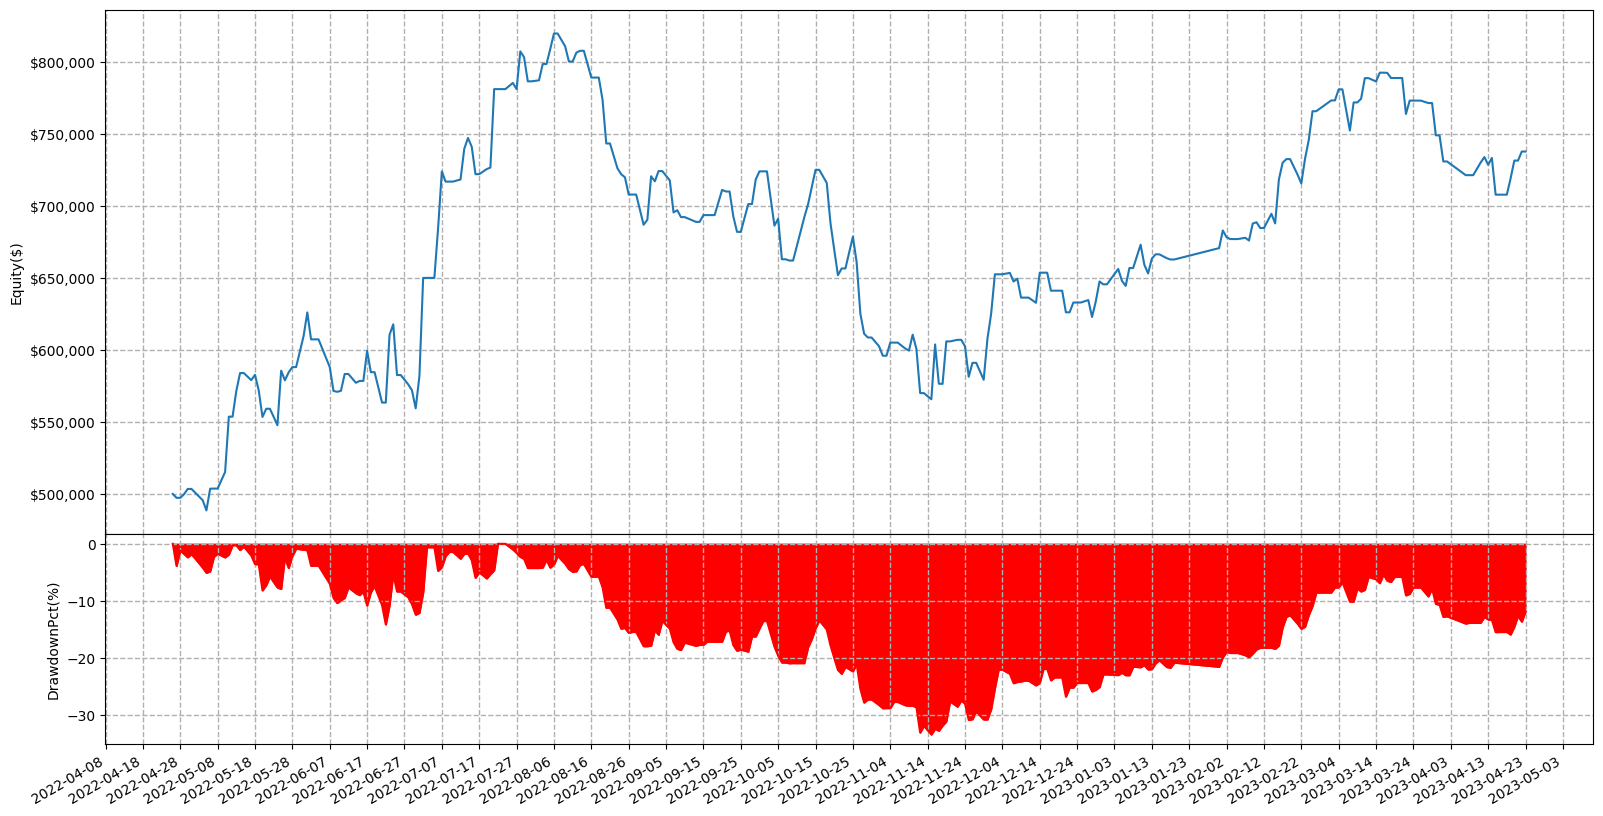

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

Start                     2022-12-24 00:10:00
End                       2023-04-22 05:00:00
Duration                    119 days 04:50:00
Exposure Time [%]                    5.027456
Equity Final [$]                  508595.1402
Equity Peak [$]                    550360.005
Return [%]                           1.719028
Buy & Hold Return [%]                9.976012
Return (Ann.) [%]                    5.001914
Volatility (Ann.) [%]               19.765147
Sharpe Ratio                         0.253067
Sortino Ratio                        0.377525
Calmar Ratio                         0.600267
Max. Drawdown [%]                   -8.332819
Avg. Drawdown [%]                   -1.221745
Max. Drawdown Duration      101 days 19:00:00
Avg. Drawdown Duration        7 days 14:29:00
# Trades                                   32
Win Rate [%]                             50.0
Best Trade [%]                       0.576122
Worst Trade [%]                     -0.703277
Avg. Trade [%]                    

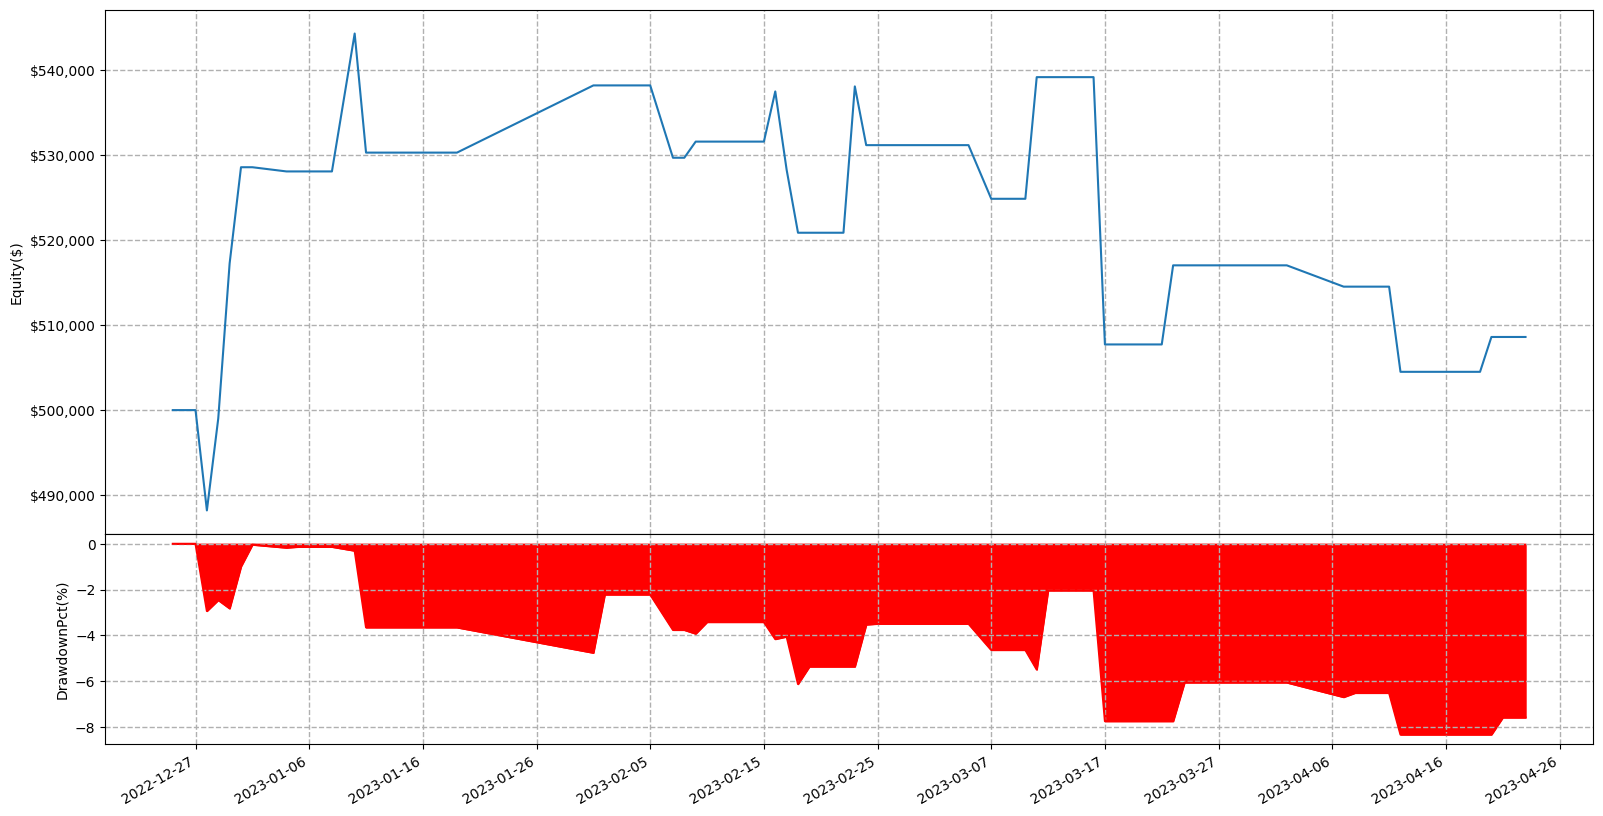

In [33]:
df_out_sample = df[df.index > '2022-12-24']
bt_out = Backtest(df_out_sample, myStrategy, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats_out = bt_out.run()
print(stats_out)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats_out._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

In [32]:
# df_in_sample = df[df.index <= '2022-12-24']
bt = Backtest(df, myStrategy, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.optimize(
                    adx_period=range(12, 36, 2),
                    rsi_period = range(12, 36, 2),
                    maximize='Equity Final [$]',
                    )
print(stats.to_string())

Backtest.optimize:   0%|          | 0/8 [00:00<?, ?it/s]

Start                                                   2022-04-25 08:50:00
End                                                     2023-04-22 05:00:00
Duration                                                  361 days 20:10:00
Exposure Time [%]                                                 15.109051
Equity Final [$]                                                737971.1518
Equity Peak [$]                                                 837671.7302
Return [%]                                                         47.59423
Buy & Hold Return [%]                                             -6.675448
Return (Ann.) [%]                                                 39.769113
Volatility (Ann.) [%]                                             48.476579
Sharpe Ratio                                                       0.820378
Sortino Ratio                                                      2.003448
Calmar Ratio                                                       1.187705
Max. Drawdow